In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../script/')
from functions import to_datetime, correct_dates, plot_model_var_imp, \
create_new_features, withdraw_information, weight_data, add_features_in_test
from loading import load_train, load_test
from prediction import build_predictor

%matplotlib inline
%load_ext autoreload
%autoreload 2

/users/home/benoumechia/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Initialization
### Load and clear the datasets

In [2]:
reload_data = True
load_full = True

categorize_features = ['user_id', 'artist_id', 'media_id', 'genre_id']
listen_type_features = ['user_id', 'media_id']
combo_features1=['user_id']
combo_features2=['genre_id', 'artist_id', 'platform_family']
target = 'is_listened'

xgb_params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "n_estimators": 10000
    }

In [3]:
if reload_data:
    nrows = None
    train = load_train(nrows=nrows, save_to_hdf=False)
    test = load_test(save_to_hdf=False)
    context_type_test = test.context_type.unique().tolist()

    correct_dates(train)
    to_datetime(train, keep_dates=True)
    correct_dates(test)
    to_datetime(test, keep_dates=True)
    test.loc[test.listen_type == 0, 'listen_type'] = 1

    train['diff_days'] = (train.dt_listen - train.dt_media).dt.days
    test['diff_days'] = (test.dt_listen - test.dt_media).dt.days
    train.drop(['dt_listen', 'dt_media'], axis=1, inplace=True)
    test.drop(['dt_listen', 'dt_media'], axis=1, inplace=True)

    create_new_features(train, 
                        context_type_test=context_type_test, 
                        features=categorize_features, 
                        listen_type_features=listen_type_features,
                        combo_features1=combo_features1,
                        combo_features2=combo_features2)

    test = add_features_in_test(train, 
                                test, 
                                features=categorize_features, 
                                listen_type_features=listen_type_features,
                                combo_features1=combo_features1,
                                combo_features2=combo_features2)
    
    if load_full:
        train_full = train
    train = train[(train.listen_type==1) & train.context_type.isin(context_type_test)].copy()
    
    train.to_pickle('../input/train_mod.pkl')
    test.to_pickle('../input/test_mod.pkl')
    if load_full:
        train_full.to_pickle('../input/train_full_mod.pkl')
else:
    train = pd.read_pickle('../input/train_mod.pkl')
    test = pd.read_pickle('../input/test_mod.pkl')
    if load_full:
        train_full = pd.read_pickle('../input/train_full_mod.pkl')

In [4]:
n_train_sample = 500000
test_size = 0.25
nbins = 10
coef_correct = 0.4748
n_rounds = 500
verbose = True

drop_features = categorize_features + ['listen_type', 'is_listened_flow', 'is_listened_context', 'is_context', 'album_id']
features = np.setdiff1d(train.columns.tolist(), drop_features + [target], assume_unique=True)
features_bis = []
for feat in features:
    if 'bis' in feat:
        features_bis.append(feat)
        
features = np.setdiff1d(features, features_bis)
features

array(['artist_id_context_count', 'artist_id_context_ratio',
       'artist_id_count', 'artist_id_ratio', 'context_type', 'day_listen',
       'diff_days', 'genre_id_context_count', 'genre_id_context_ratio',
       'genre_id_count', 'genre_id_ratio', 'hour_listen', 'media_duration',
       'media_id_context_count', 'media_id_context_ratio',
       'media_id_count', 'media_id_listen_type_count', 'media_id_ratio',
       'media_id_ratio_flow', 'platform_family', 'platform_name',
       'user_age', 'user_gender', 'user_id_artist_id_context_count',
       'user_id_artist_id_context_ratio', 'user_id_artist_id_count',
       'user_id_artist_id_listen_type_count', 'user_id_artist_id_ratio',
       'user_id_artist_id_ratio_flow', 'user_id_context_count',
       'user_id_context_ratio', 'user_id_count',
       'user_id_genre_id_context_count', 'user_id_genre_id_context_ratio',
       'user_id_genre_id_count', 'user_id_genre_id_listen_type_count',
       'user_id_genre_id_ratio', 'user_id_genre_

In [5]:
features_4_test_correction = ['user_id', 'artist_id', 'media_id', 'genre_id']

new_drop_features = []
for feature in categorize_features:
    new_drop_features.append(feature + '_count')
    new_drop_features.append(feature + '_ratio')
    new_drop_features.append(feature + '_context_count')
    new_drop_features.append(feature + '_context_ratio')
    new_drop_features.append(feature + '_listen_type_count')
    new_drop_features.append(feature + '_ratio_flow')
    
for feat1 in combo_features1:
    for feat2 in combo_features2:
        new_drop_features.append(feat1 + '_' + feat2 + '_count')
        new_drop_features.append(feat1 + '_' + feat2 + '_ratio')
        new_drop_features.append(feat1 + '_' + feat2 + '_context_count')
        new_drop_features.append(feat1 + '_' + feat2 + '_context_ratio')
        new_drop_features.append(feat1 + '_' + feat2 + '_listen_type_count')
        new_drop_features.append(feat1 + '_' + feat2 + '_ratio_flow')
        
features_4_weight = np.setdiff1d(features, new_drop_features + features_bis).tolist() + [feat + '_context_count_bis' for feat in features_4_test_correction]

### First model with all features

In [6]:
def skopt_get_model(params, with_train_test=False, test_more=None):
    """
    """
    n_context_type = params[0]
    xgb_params['eta'] = params[1]
    xgb_params['gamma'] = params[2]
    xgb_params['max_depth'] = params[3]
    xgb_params['min_child_weight'] = params[4]
    xgb_params['max_delta_step'] = params[5]
    xgb_params['subsample'] = params[6]
    xgb_params['colsample_bytree'] = params[7]
    xgb_params['colsample_bylevel'] = params[8]
    xgb_params['reg_lambda'] = params[9]
    xgb_params['reg_alpha'] = params[10]
    coef_correct_1 = params[11]
    coef_correct_2 = 0.4158
    coef_correct_3 = 0.0654

    gbm, auc, *train_test = build_predictor(train.copy(),
                                            test,
                                       features,
                                       xgb_params, 
                                       n_train_sample=n_train_sample, 
                                       test_size=test_size, 
                                       nbins=nbins, 
                                       coef_correct_1=coef_correct_1, 
                                       coef_correct_2=coef_correct_2, 
                                       coef_correct_3=coef_correct_3, 
                                       n_context_type=n_context_type, 
                                       categorize_features=categorize_features, 
                                       n_rounds=n_rounds,
                                       verbose=verbose,
                                       return_train_test=with_train_test,
                                       features_4_weight=features_4_weight,
                                       features_4_test_correction=features_4_test_correction)
    
    if with_train_test:
        return gbm, auc, train_test
    else:
        return gbm, auc

In [16]:
params = [5,
 0.17407051336154253,
 0.013916566990960999,
 4,
 9,
 6,
 0.7,
 0.71130311096031629,
 0.7,
 1.,
 0.,
 0.49587330976816746]

users_in_train = train.user_id.unique()
users_not_in_train = np.setdiff1d(test.user_id.unique(), users_in_train)
ids_not_in_trainfull = train_full.user_id.isin(users_not_in_train)
train_not_used = train_full[ids_not_in_trainfull].drop(['listen_type'], axis=1)

gbm_1, auc_1, train_test_1 = skopt_get_model(params, True)

[0]	train-auc:0.668253	eval-auc:0.66956
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 30 rounds.
[1]	train-auc:0.68906	eval-auc:0.688646
[2]	train-auc:0.693198	eval-auc:0.691182
[3]	train-auc:0.693073	eval-auc:0.692388
[4]	train-auc:0.696443	eval-auc:0.695266
[5]	train-auc:0.697045	eval-auc:0.695352
[6]	train-auc:0.698513	eval-auc:0.696634
[7]	train-auc:0.699746	eval-auc:0.697744
[8]	train-auc:0.70361	eval-auc:0.70189
[9]	train-auc:0.705276	eval-auc:0.703294
[10]	train-auc:0.70676	eval-auc:0.705104
[11]	train-auc:0.707887	eval-auc:0.70566
[12]	train-auc:0.708251	eval-auc:0.706319
[13]	train-auc:0.708781	eval-auc:0.706638
[14]	train-auc:0.709471	eval-auc:0.707188
[15]	train-auc:0.709987	eval-auc:0.707577
[16]	train-auc:0.711346	eval-auc:0.708954
[17]	train-auc:0.711449	eval-auc:0.709011
[18]	train-auc:0.711959	eval-auc:0.709336
[19]	train-auc:0.712605	eval-auc:0.709581
[20]	train-auc:0.713567	eval-auc:0.

[86]	train-auc:0.737	eval-auc:0.711481
[87]	train-auc:0.737128	eval-auc:0.711472
[88]	train-auc:0.737303	eval-auc:0.711367
[89]	train-auc:0.7376	eval-auc:0.711108
[90]	train-auc:0.737764	eval-auc:0.711016
[91]	train-auc:0.738042	eval-auc:0.711212
[92]	train-auc:0.738464	eval-auc:0.71133
[93]	train-auc:0.738725	eval-auc:0.711317
[94]	train-auc:0.739043	eval-auc:0.711269
[95]	train-auc:0.73934	eval-auc:0.71121
[96]	train-auc:0.739592	eval-auc:0.711324
[97]	train-auc:0.739893	eval-auc:0.711482
[98]	train-auc:0.740069	eval-auc:0.711493
[99]	train-auc:0.740213	eval-auc:0.711557
[100]	train-auc:0.740401	eval-auc:0.711362
[101]	train-auc:0.740687	eval-auc:0.711428
[102]	train-auc:0.740781	eval-auc:0.711397
[103]	train-auc:0.740893	eval-auc:0.71138
[104]	train-auc:0.741178	eval-auc:0.711285
[105]	train-auc:0.741453	eval-auc:0.71149
[106]	train-auc:0.7416	eval-auc:0.711621
[107]	train-auc:0.741861	eval-auc:0.71165
[108]	train-auc:0.74223	eval-auc:0.711687
[109]	train-auc:0.74227	eval-auc:0.7116

[79]	train-auc:0.731563	eval-auc:0.713938
[80]	train-auc:0.73178	eval-auc:0.713949
[81]	train-auc:0.732021	eval-auc:0.714137
[82]	train-auc:0.732326	eval-auc:0.714229
[83]	train-auc:0.732502	eval-auc:0.714218
[84]	train-auc:0.732713	eval-auc:0.713999
[85]	train-auc:0.733243	eval-auc:0.71409
[86]	train-auc:0.733455	eval-auc:0.714058
[87]	train-auc:0.733792	eval-auc:0.714202
[88]	train-auc:0.734275	eval-auc:0.713955
[89]	train-auc:0.734418	eval-auc:0.714009
[90]	train-auc:0.734617	eval-auc:0.714108
[91]	train-auc:0.734974	eval-auc:0.714105
[92]	train-auc:0.735203	eval-auc:0.714192
[93]	train-auc:0.735277	eval-auc:0.714204
[94]	train-auc:0.735595	eval-auc:0.71414
[95]	train-auc:0.73581	eval-auc:0.714211
[96]	train-auc:0.735884	eval-auc:0.714137
[97]	train-auc:0.736002	eval-auc:0.714195
[98]	train-auc:0.736192	eval-auc:0.71442
[99]	train-auc:0.736386	eval-auc:0.714417
[100]	train-auc:0.736709	eval-auc:0.714709
[101]	train-auc:0.736924	eval-auc:0.714658
[102]	train-auc:0.737115	eval-auc:0.7

[39]	train-auc:0.722998	eval-auc:0.707106
[40]	train-auc:0.723428	eval-auc:0.707356
[41]	train-auc:0.723665	eval-auc:0.707234
[42]	train-auc:0.72406	eval-auc:0.706864
[43]	train-auc:0.724499	eval-auc:0.707053
[44]	train-auc:0.724766	eval-auc:0.70704
[45]	train-auc:0.725085	eval-auc:0.70709
[46]	train-auc:0.725951	eval-auc:0.708249
[47]	train-auc:0.726148	eval-auc:0.708066
[48]	train-auc:0.726367	eval-auc:0.708566
[49]	train-auc:0.726622	eval-auc:0.708624
[50]	train-auc:0.726959	eval-auc:0.708323
[51]	train-auc:0.727168	eval-auc:0.708283
[52]	train-auc:0.727404	eval-auc:0.708446
[53]	train-auc:0.727779	eval-auc:0.708355
[54]	train-auc:0.728003	eval-auc:0.708523
[55]	train-auc:0.728222	eval-auc:0.708472
[56]	train-auc:0.728316	eval-auc:0.708467
[57]	train-auc:0.728537	eval-auc:0.70848
[58]	train-auc:0.728748	eval-auc:0.708546
[59]	train-auc:0.728913	eval-auc:0.708395
[60]	train-auc:0.729145	eval-auc:0.708597
[61]	train-auc:0.729354	eval-auc:0.708622
[62]	train-auc:0.72955	eval-auc:0.7085

[136]	train-auc:0.746161	eval-auc:0.714843
[137]	train-auc:0.746282	eval-auc:0.71498
[138]	train-auc:0.74644	eval-auc:0.714926
[139]	train-auc:0.746593	eval-auc:0.714894
[140]	train-auc:0.746822	eval-auc:0.714906
[141]	train-auc:0.746919	eval-auc:0.714901
[142]	train-auc:0.747204	eval-auc:0.714793
[143]	train-auc:0.74751	eval-auc:0.714786
[144]	train-auc:0.747598	eval-auc:0.714726
[145]	train-auc:0.747784	eval-auc:0.714637
[146]	train-auc:0.748056	eval-auc:0.714552
[147]	train-auc:0.748312	eval-auc:0.714893
[148]	train-auc:0.748585	eval-auc:0.714921
[149]	train-auc:0.74877	eval-auc:0.714822
[150]	train-auc:0.748981	eval-auc:0.714819
[151]	train-auc:0.749201	eval-auc:0.714788
[152]	train-auc:0.749359	eval-auc:0.714653
[153]	train-auc:0.749608	eval-auc:0.71462
[154]	train-auc:0.749824	eval-auc:0.714557
[155]	train-auc:0.749892	eval-auc:0.714463
[156]	train-auc:0.750012	eval-auc:0.714435
[157]	train-auc:0.750188	eval-auc:0.714482
[158]	train-auc:0.750421	eval-auc:0.714434
[159]	train-auc:

In [17]:
y_sub_model_1 = gbm_1.predict(xgb.DMatrix(test[features]))

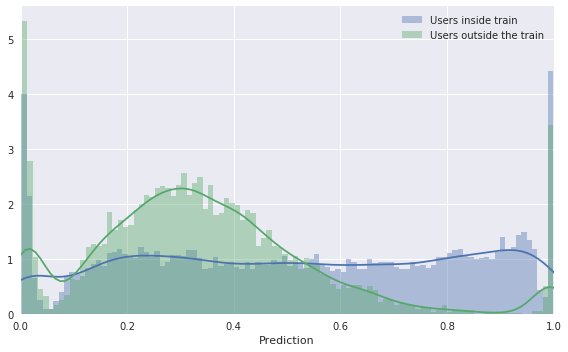

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(y_sub_model_1[test.user_id.isin(users_in_train)], bins=100, label='Users inside train')
sns.distplot(y_sub_model_1[~test.user_id.isin(users_in_train)], bins=100, label='Users outside the train');
ax.set_xlabel('Prediction')
ax.set_xlim(0, 1)
ax.legend(loc=0)
fig.tight_layout()

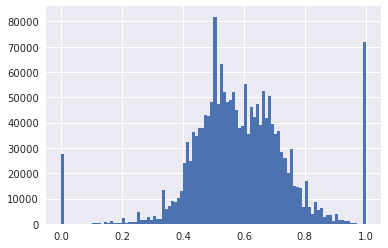

In [19]:
train.media_id_ratio_flow.hist(bins=100)

In [38]:
df = test[test.user_id.isin(users_in_train)][y_sub_model_1[test.user_id.isin(users_in_train)] < 0.1]

In [42]:
train_full[train_full['media_id'] == 683078]

,genre_id,media_id,album_id,context_type,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,...,user_id_artist_id_ratio_flow,user_id_platform_family_count,user_id_platform_family_count_bis,user_id_platform_family_ratio,user_id_platform_family_context_count,user_id_platform_family_context_count_bis,user_id_platform_family_context_ratio,user_id_platform_family_listen_type_count,user_id_platform_family_listen_type_count_bis,user_id_platform_family_ratio_flow
108,50,683078,82356,9,0,0,542,0,0,1095,...,0.0,868,868,0.519585,2,2,0.000000,447,447,0.371365
109,50,683078,82356,10,2,1,542,0,0,739,...,0.0,216,216,1.000000,0,0,0.000000,0,0,0.000000
110,50,683078,82356,0,1,0,542,0,0,12257,...,0.0,125,125,0.344000,0,0,0.000000,0,0,0.000000
114,50,683078,82356,0,0,0,542,0,0,3549,...,0.0,352,352,0.514205,0,0,0.000000,0,0,0.000000
116,50,683078,82356,0,0,0,542,0,1,5670,...,0.0,395,395,0.554430,162,162,0.549383,166,166,0.548193
123,50,683078,82356,0,0,0,542,0,0,3549,...,0.0,352,352,0.514205,0,0,0.000000,0,0,0.000000


In [43]:
df.iloc[0][features]

artist_id_context_count                        319.000000
artist_id_context_ratio                          0.605016
artist_id_count                               1111.000000
artist_id_ratio                                  0.660666
context_type                                     1.000000
day_listen                                       2.000000
diff_days                                     5139.000000
genre_id_context_count                       29748.000000
genre_id_context_ratio                           0.505950
genre_id_count                               79158.000000
genre_id_ratio                                   0.612383
hour_listen                                     16.000000
media_duration                                 542.000000
media_id_context_count                           0.000000
media_id_context_ratio                           0.000000
media_id_count                                   6.000000
media_id_listen_type_count                       0.000000
media_id_ratio

In [ ]:
train.groupby

In [74]:
df.columns

Index(['sample_id', 'genre_id', 'media_id', 'album_id', 'context_type',
       'platform_name', 'platform_family', 'media_duration', 'listen_type',
       'user_gender', 'user_id', 'artist_id', 'user_age', 'day_listen',
       'hour_listen', 'year_media', 'diff_days', 'user_id_count',
       'user_id_ratio', 'user_id_context_count', 'user_id_context_ratio',
       'user_id_listen_type_count', 'user_id_ratio_flow', 'artist_id_count',
       'artist_id_ratio', 'artist_id_context_count', 'artist_id_context_ratio',
       'media_id_count', 'media_id_ratio', 'media_id_context_count',
       'media_id_context_ratio', 'media_id_listen_type_count',
       'media_id_ratio_flow', 'user_id_genre_id_count',
       'user_id_genre_id_ratio', 'user_id_genre_id_context_count',
       'user_id_genre_id_context_ratio', 'user_id_genre_id_listen_type_count',
       'user_id_genre_id_ratio_flow', 'user_id_artist_id_count',
       'user_id_artist_id_ratio', 'user_id_artist_id_context_count',
       'user_id

In [75]:
df[['media_id_listen_type_count', 'media_id_ratio_flow']]

,media_id_listen_type_count,media_id_ratio_flow
0,0.0,0.000000
24,1.0,0.000000
84,NaN,NaN
89,0.0,0.000000
91,0.0,0.000000
93,1.0,0.000000
182,0.0,0.000000
208,0.0,0.000000
209,0.0,0.000000
213,NaN,NaN


As we can see, the new features seems to be very predictive

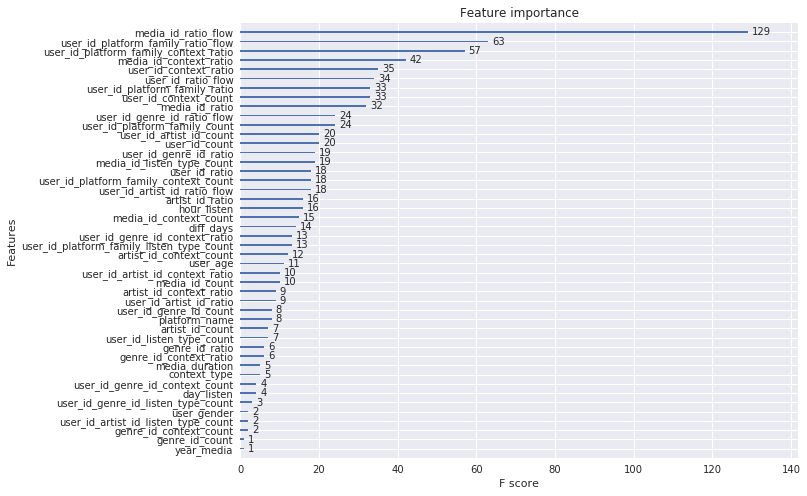

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(gbm_1, ax=ax)

In [36]:
y_pred_not_used = gbm_1.predict(xgb.DMatrix(train_not_used[features]))
roc_auc_score(train_not_used.is_listened, y_pred_not_used)

0.59423120654337613

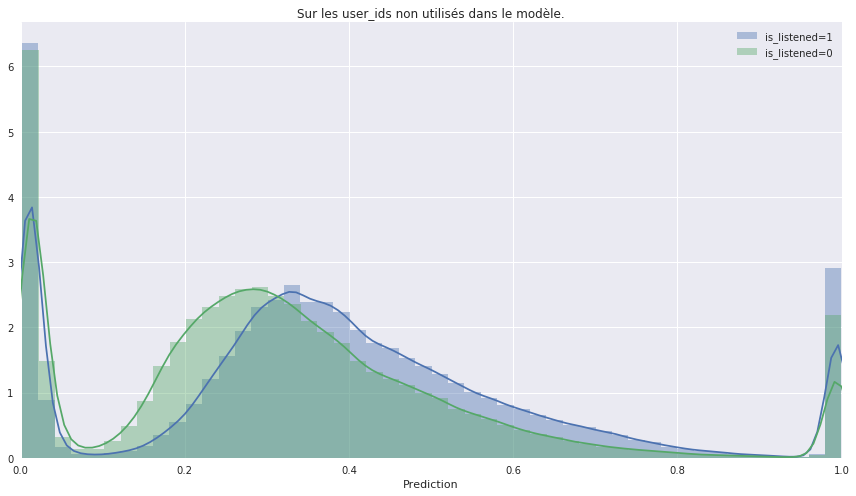

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred_not_used[train_not_used.is_listened == 1], label="is_listened=1")
sns.distplot(y_pred_not_used[train_not_used.is_listened == 0], label="is_listened=0")
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur les user_ids non utilisés dans le modèle.")
fig.tight_layout()

In [79]:
df = train_not_used[y_pred_not_used > 0.9]

In [80]:
df.media_id_listen_type_count

66          1
111         1
1885        1
1982        2
2110        2
2471        3
2472        3
2475        3
3041        4
3155        4
3188        3
3189        3
3338        3
3520        5
3625        5
3689        3
3691        5
3694        1
3733        5
3771        4
4344        1
4546        8
4565        8
4566        8
4567        8
4568        8
4578        8
4589        8
4590        8
4602        8
           ..
7557252     3
7557253     3
7557254     3
7557255     3
7557271    10
7557272    10
7557273    10
7557276    10
7557279    10
7557280    10
7557281    10
7557282    10
7557283    10
7557284    10
7557292    10
7557293    10
7557294    10
7557295    10
7557301    10
7557302    10
7557308     6
7557447     7
7557505     1
7557506     1
7557507     1
7557720     2
7557722     2
7557737     2
7558107     1
7558108     1
Name: media_id_listen_type_count, Length: 60571, dtype: int64

## New features for a second model

In [81]:
features

array(['genre_id', 'context_type', 'platform_name', 'platform_family',
       'media_duration', 'user_gender', 'user_age', 'day_listen',
       'hour_listen', 'year_media', 'diff_days', 'user_id_count',
       'user_id_ratio', 'user_id_context_count', 'user_id_context_ratio',
       'user_id_listen_type_count', 'user_id_ratio_flow',
       'artist_id_count', 'artist_id_ratio', 'artist_id_context_count',
       'artist_id_context_ratio', 'media_id_count', 'media_id_ratio',
       'media_id_context_count', 'media_id_context_ratio',
       'media_id_listen_type_count', 'media_id_ratio_flow',
       'user_id_genre_id_count', 'user_id_genre_id_ratio',
       'user_id_genre_id_context_count', 'user_id_genre_id_context_ratio',
       'user_id_genre_id_listen_type_count', 'user_id_genre_id_ratio_flow',
       'user_id_artist_id_count', 'user_id_artist_id_ratio',
       'user_id_artist_id_context_count',
       'user_id_artist_id_context_ratio',
       'user_id_artist_id_listen_type_count',
   

In [82]:
new_drop_features = []
for feature in categorize_features:
    new_drop_features.append(feature + '_context_count')
    new_drop_features.append(feature + '_context_ratio')
    new_drop_features.append(feature + '_listen_type_count')
    new_drop_features.append(feature + '_ratio_flow')
    
for feat1 in combo_features1:
    for feat2 in combo_features2:
        new_drop_features.append(feat1 + '_' + feat2 + '_context_count')
        new_drop_features.append(feat1 + '_' + feat2 + '_context_ratio')
        new_drop_features.append(feat1 + '_' + feat2 + '_listen_type_count')
        new_drop_features.append(feat1 + '_' + feat2 + '_ratio_flow')
        
features = np.setdiff1d(features, new_drop_features)

In [83]:
gbm_2, auc_2, train_test_2 = skopt_get_model(params, True)

[0]	train-auc:0.696618	eval-auc:0.669455
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 30 rounds.
[1]	train-auc:0.711645	eval-auc:0.677188
[2]	train-auc:0.717632	eval-auc:0.681502
[3]	train-auc:0.721355	eval-auc:0.689112
[4]	train-auc:0.724155	eval-auc:0.69048
[5]	train-auc:0.729259	eval-auc:0.692822
[6]	train-auc:0.732216	eval-auc:0.694389
[7]	train-auc:0.733211	eval-auc:0.695317
[8]	train-auc:0.735346	eval-auc:0.697977
[9]	train-auc:0.737439	eval-auc:0.698455
[10]	train-auc:0.73992	eval-auc:0.69916
[11]	train-auc:0.740779	eval-auc:0.69975
[12]	train-auc:0.743429	eval-auc:0.699638
[13]	train-auc:0.746037	eval-auc:0.700202
[14]	train-auc:0.747893	eval-auc:0.700912
[15]	train-auc:0.749304	eval-auc:0.701489
[16]	train-auc:0.750677	eval-auc:0.701103
[17]	train-auc:0.753094	eval-auc:0.699664
[18]	train-auc:0.754787	eval-auc:0.699411
[19]	train-auc:0.756203	eval-auc:0.699065
[20]	train-auc:0.7581	eval-auc:0.

In [84]:
auc_2

0.69449448926571811

In [85]:
y_sub_model_2 = gbm_2.predict(xgb.DMatrix(test[features]))

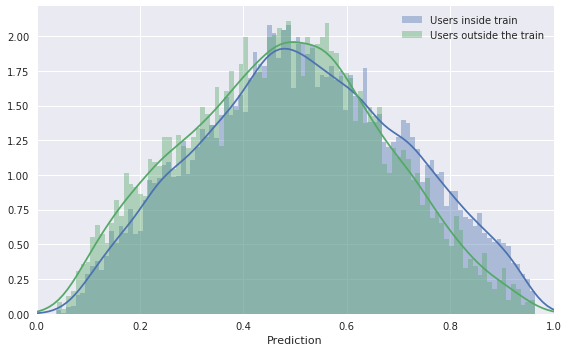

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(y_sub_model_2[test.user_id.isin(users_in_train)], bins=100, label='Users inside train')
sns.distplot(y_sub_model_2[~test.user_id.isin(users_in_train)], bins=100, label='Users outside the train');
ax.set_xlabel('Prediction')
ax.set_xlim(0, 1)
ax.legend(loc=0)
fig.tight_layout()

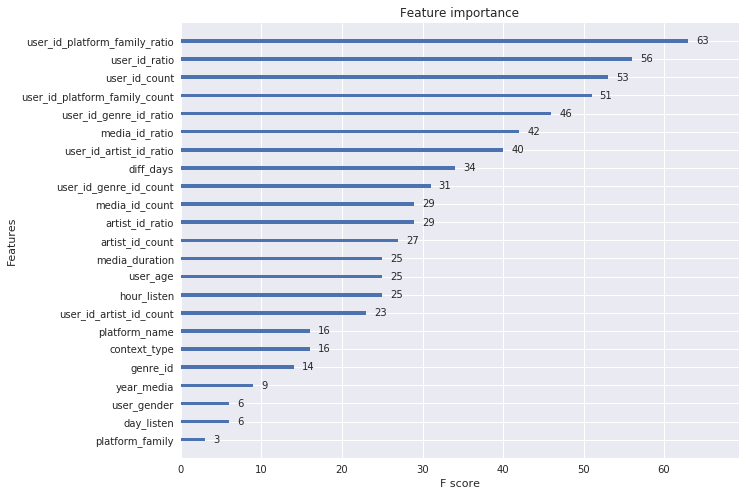

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(gbm_2, ax=ax)

In [26]:
y_pred_not_used = gbm_2.predict(xgb.DMatrix(train_not_used[features]))
roc_auc_score(train_not_used.is_listened, y_pred_not_used)

0.80337232711765871

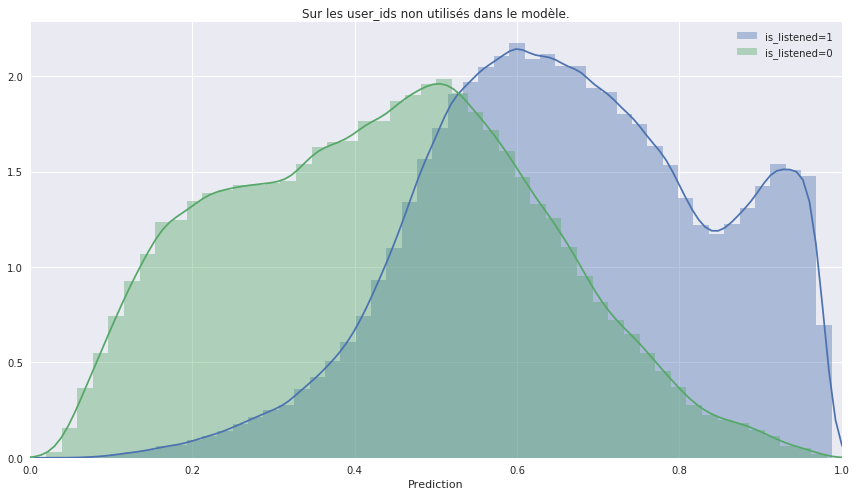

In [28]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred_not_used[train_not_used.is_listened == 1], label="is_listened=1")
sns.distplot(y_pred_not_used[train_not_used.is_listened == 0], label="is_listened=0")
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur les user_ids non utilisés dans le modèle.")
fig.tight_layout()

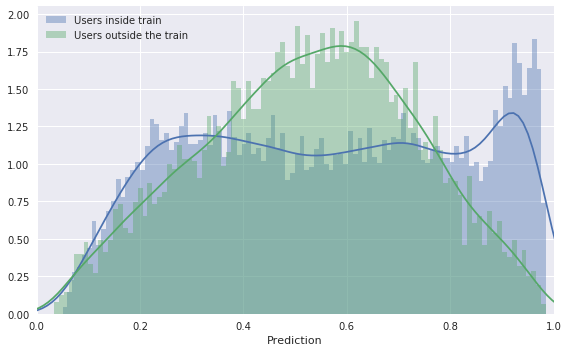

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(y_sub_model_1[test.user_id.isin(users_in_train)], bins=100, label='Users inside train')
sns.distplot(y_sub_model_2[~test.user_id.isin(users_in_train)], bins=100, label='Users outside the train');
ax.set_xlabel('Prediction')
ax.set_xlim(0, 1)
ax.legend(loc=0)
fig.tight_layout()

In [42]:
y_sub = np.zeros(y_sub_model_1.shape)
y_sub[test.user_id.isin(users_in_train)] = y_sub_model_1[test.user_id.isin(users_in_train)]
y_sub[~test.user_id.isin(users_in_train)] = y_sub_model_2[~test.user_id.isin(users_in_train)]

In [48]:
sub = pd.DataFrame({'is_listened': y_sub})
sub.index.name = 'sample_id'
sub.to_csv('../output/features_conditionelles_cv_%.5f.csv' % ((auc_1 + auc_2)*0.5))

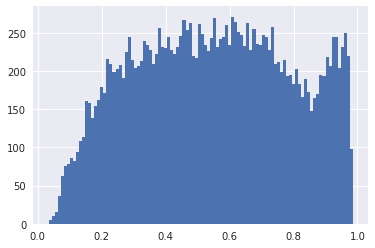

In [49]:
plt.hist(y_sub, bins=100);

In [49]:
train_not_used = train_full[ids_not_in_trainfull].drop(['listen_type'], axis=1)

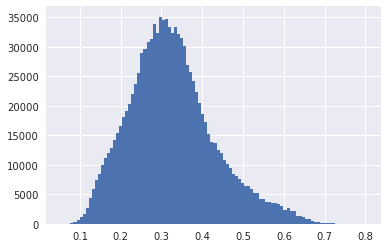

In [74]:
plt.hist(y_pred_not_used, bins=100);

0.69303611646536833

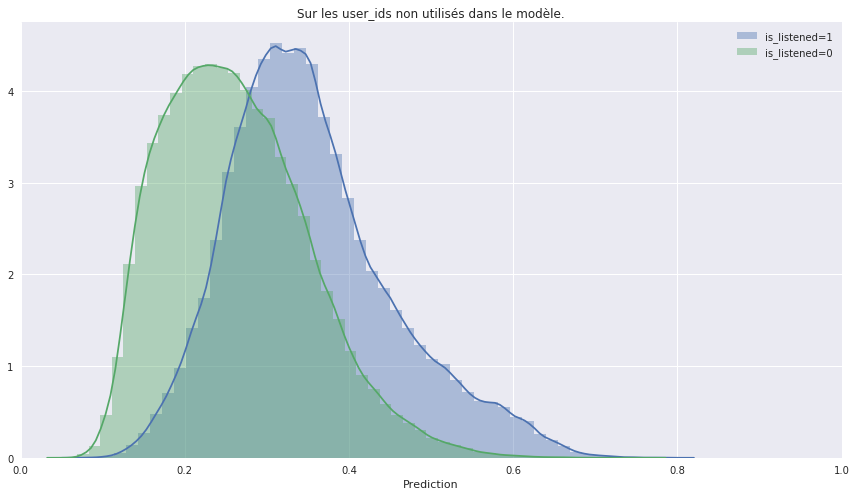

In [70]:
is_listened_not_used = train_not_used.is_listened == 1

fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred_not_used[is_listened_not_used], label="is_listened=1")
sns.distplot(y_pred_not_used[~is_listened_not_used], label="is_listened=0")
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur les user_ids non utilisés dans le modèle.")
fig.tight_layout()

In [38]:
context_type_test = test.context_type.unique().tolist()

In [39]:
features

array(['genre_id', 'context_type', 'platform_name', 'platform_family',
       'media_duration', 'user_gender', 'user_age', 'day_listen',
       'hour_listen', 'year_media', 'diff_days', 'user_id_count',
       'user_id_ratio', 'user_id_context_count', 'user_id_context_ratio',
       'user_id_listen_type_count', 'user_id_ratio_flow',
       'artist_id_count', 'artist_id_ratio', 'artist_id_context_count',
       'artist_id_context_ratio', 'media_id_count', 'media_id_ratio',
       'media_id_context_count', 'media_id_context_ratio',
       'user_id_genre_id_count', 'user_id_genre_id_ratio',
       'user_id_genre_id_context_count', 'user_id_genre_id_context_ratio',
       'user_id_genre_id_listen_type_count', 'user_id_genre_id_ratio_flow',
       'user_id_artist_id_count', 'user_id_artist_id_ratio',
       'user_id_artist_id_context_count',
       'user_id_artist_id_context_ratio',
       'user_id_artist_id_listen_type_count',
       'user_id_artist_id_ratio_flow', 'user_id_platform_family

In [59]:
train_sample, test_sample = train_test
y_pred = gbm.predict(xgb.DMatrix(train_sample[features]))

ValueError: not enough values to unpack (expected 2, got 0)

In [60]:
feat = 'context_type'
i = context_type_test[0]
ids_low_count = test_sample[feat] == i
is_listened_low_counts = test_sample.is_listened

fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred[ids_low_count & is_listened_low_counts], label="is_listened=1 & %s = %d" % (feat, i))
sns.distplot(y_pred[ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s = %d" % (feat, i))
# sns.distplot(y_pred[~ids_low_count & is_listened_low_counts], label="is_listened=1 & %s >= %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s >= %d" % (feat, n_context))
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

NameError: name 'test_sample' is not defined

/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666
/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666


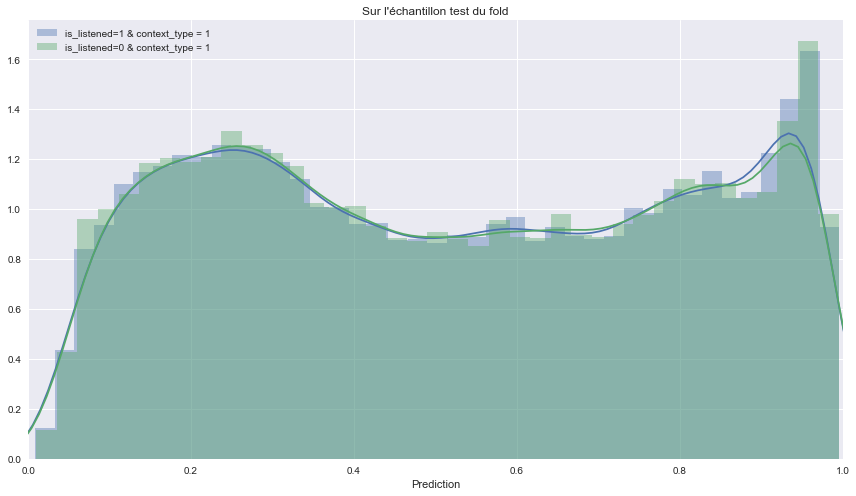

In [25]:
feat = 'context_type'
i = context_type_test[0]
ids_low_count = test_sample[feat] == i
is_listened_low_counts = test_sample.is_listened

fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred[ids_low_count & is_listened_low_counts], label="is_listened=1 & %s = %d" % (feat, i))
sns.distplot(y_pred[ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s = %d" % (feat, i))
# sns.distplot(y_pred[~ids_low_count & is_listened_low_counts], label="is_listened=1 & %s >= %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s >= %d" % (feat, n_context))
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666
/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666


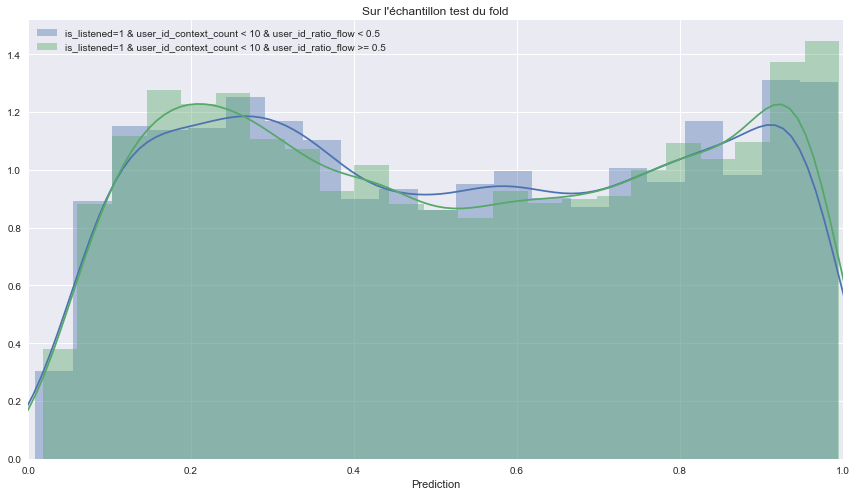

In [26]:
n_context = 10
threshold2 = 0.5
feat = 'user_id_context_count'
feat2 = 'user_id_ratio_flow'
ids_low_count = test_sample[feat] < n_context
ids_ratio_flow = test_sample[feat2] < threshold2
is_listened_low_counts = test_sample.is_listened

fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred[is_listened_low_counts & ids_low_count & ids_ratio_flow], 
             label="is_listened=1 & %s < %d & %s < %.1f" % (feat, n_context, feat2, threshold2))
sns.distplot(y_pred[is_listened_low_counts & ids_low_count & ~ids_ratio_flow], 
             label="is_listened=1 & %s < %d & %s >= %.1f" % (feat, n_context, feat2, threshold2))
# sns.distplot(y_pred[ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s < %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & is_listened_low_counts], label="is_listened=1 & %s >= %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s >= %d" % (feat, n_context))
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666


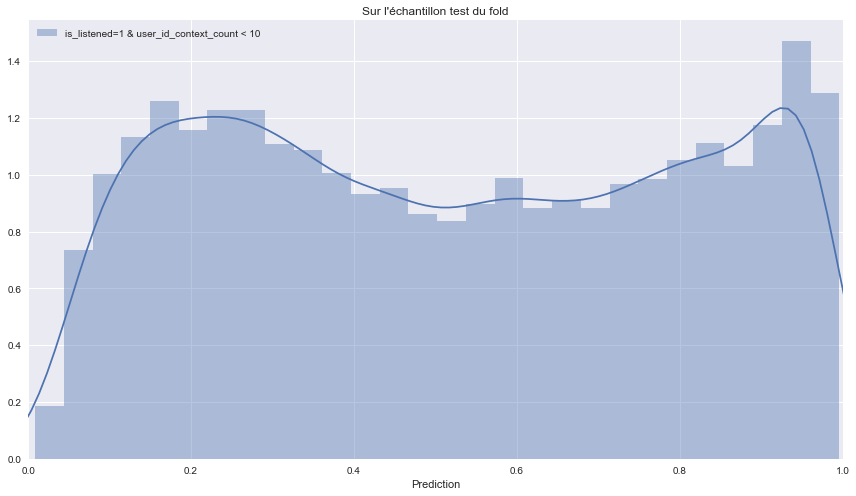

In [27]:
n_context = 10
feat = 'user_id_context_count'
ids_low_count = test_sample[feat] < n_context
is_listened_low_counts = test_sample.is_listened

fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(y_pred[ids_low_count & is_listened_low_counts], label="is_listened=1 & %s < %d" % (feat, n_context))
# sns.distplot(y_pred[ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s < %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & is_listened_low_counts], label="is_listened=1 & %s >= %d" % (feat, n_context))
# sns.distplot(y_pred[~ids_low_count & ~is_listened_low_counts], label="is_listened=0 & %s >= %d" % (feat, n_context))
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

NameError: name 'test_context_type' is not defined

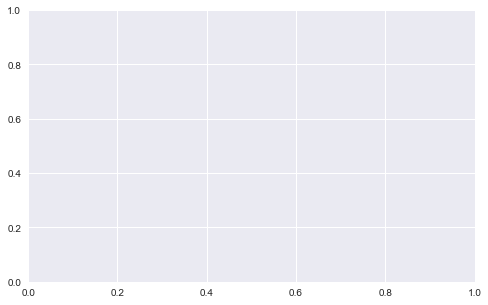

In [28]:
n_context = 5
ids_low_count = test_sample.user_id_context_count < n_context
ids_listened = test_sample.context_type == True

fig, ax = plt.subplots(figsize=(8, 5))
for i in test_context_type:
    sns.distplot(y_pred[test_sample.context_type == i], label="context_type=%d" % (i))
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666
/home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 166666


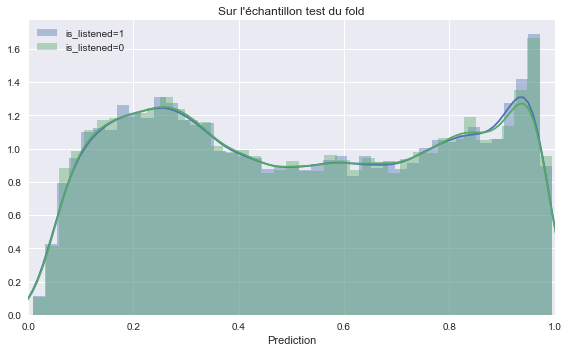

In [29]:
n_context = 5
ids_low_count = test_sample.user_id_context_count < n_context
ids_listened = test_sample.is_listened == True

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(y_pred[ids_listened], label="is_listened=1")
sns.distplot(y_pred[~ids_listened], label="is_listened=0")
ax.legend(loc=0)
ax.set_xlim(0, 1)
ax.set_xlabel('Prediction')
ax.set_title("Sur l'échantillon test du fold")
fig.tight_layout()

In [30]:
list_user_id = train.user_id.value_counts().index.values
missing_user_id = np.setdiff1d(test.user_id.unique(), list_user_id)

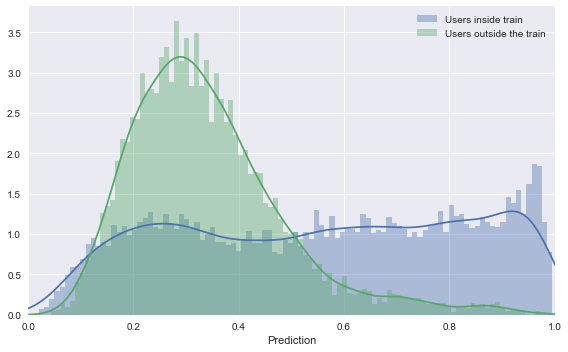

In [31]:
sub = gbm.predict(xgb.DMatrix(test[features]))
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(sub[test.user_id.isin(list_user_id)], bins=100, label='Users inside train')
sns.distplot(sub[~test.user_id.isin(list_user_id)], bins=100, label='Users outside the train');
ax.set_xlabel('Prediction')
ax.set_xlim(0, 1)
ax.legend(loc=0)
fig.tight_layout()

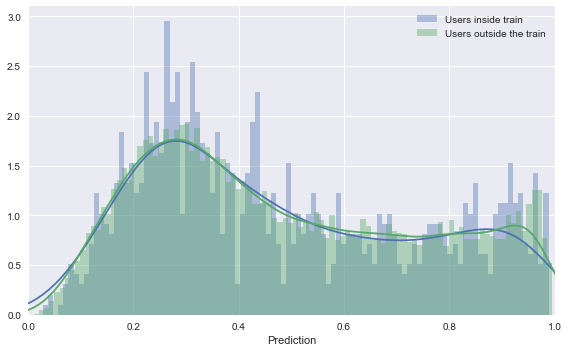

In [32]:
ids_low_count = test.user_id_count < 10

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(sub[test.user_id[ids_low_count]], bins=100, label='Users inside train')
sns.distplot(sub[test.user_id[~ids_low_count]], bins=100, label='Users outside the train');
ax.set_xlabel('Prediction')
ax.set_xlim(0, 1)
ax.legend(loc=0)
fig.tight_layout()